In [1]:
# !pip install xgboost

In [2]:
# library
# basic data analysis and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#preprocessing
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, plot_precision_recall_curve, plot_roc_curve

# models
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Data

In [3]:
df= pd.read_csv('adult.csv')
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [4]:
df.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


# Missing Value

In [6]:
df.replace('?', np.nan).isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

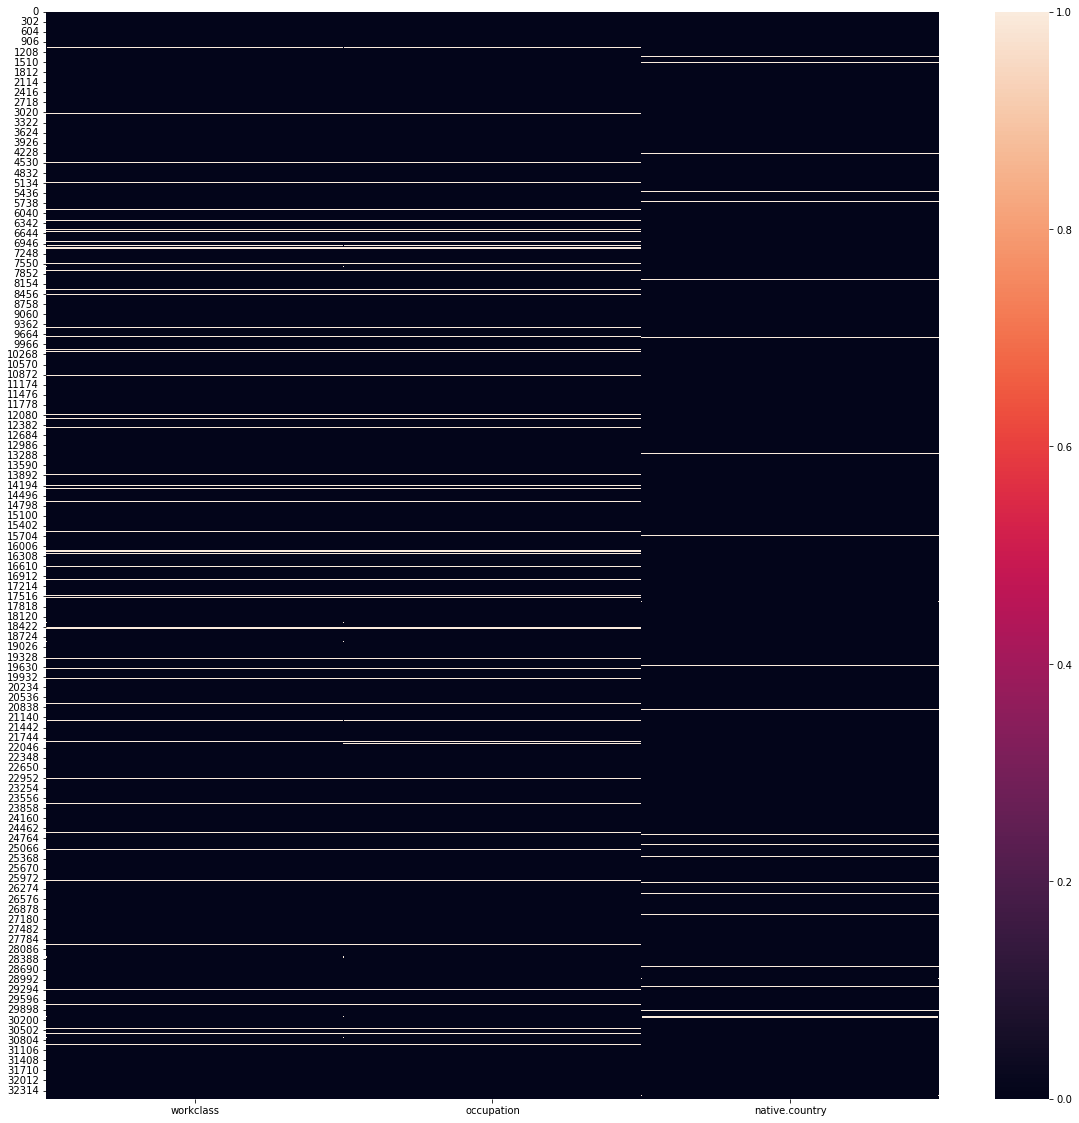

In [8]:
plt.figure(figsize=(20,20))
sns.heatmap(df.replace('?',np.nan)[['workclass','occupation','native.country']].isna())

In [9]:
df.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


# Preprocessing

* Missing Value: simple imputer with constant (sudah constant ditandai dengan ?)
* one hot encoding: relationship, race, sex --> jumlah kategori tidak terlalu banyak, tipe data nominal
* binary encoding: workclass, marital.status, occupation,native.country --> nominal dengan kategori cukup banyak
* ordinal: education (alredy done)
* no treatment: numerical --> karena pakai decision tree
* drop: fnlwgt

In [10]:
transformer= ColumnTransformer([
    ('one hot', OneHotEncoder(drop='first'),['relationship', 'race', 'sex']),
    ('binary', ce.BinaryEncoder(drop_invariant=True),['workclass', 'marital.status', 'occupation','native.country'])
],remainder='passthrough')

In [11]:
# cek apakah transformer jalan
transformer.fit_transform(df)

array([[1.0, 0.0, 0.0, ..., 4356, 40, '<=50K'],
       [1.0, 0.0, 0.0, ..., 4356, 18, '<=50K'],
       [0.0, 0.0, 0.0, ..., 4356, 40, '<=50K'],
       ...,
       [0.0, 0.0, 0.0, ..., 0, 40, '>50K'],
       [0.0, 0.0, 0.0, ..., 0, 40, '<=50K'],
       [0.0, 0.0, 1.0, ..., 0, 20, '<=50K']], dtype=object)

# Data Splitting

In [13]:
x=df.drop(columns=['fnlwgt','income','education'])
y=np.where(df['income']=='>50K',1,0)

In [15]:
y.sum()

7841

In [17]:
x_train, x_test, y_train, y_test= train_test_split(x,y,
                                                  stratify=y,
                                                  random_state=10)

# Comparing models
## Decision Tree

In [18]:
model= DecisionTreeClassifier(max_depth=3)
pipe=Pipeline([
    ('preprocess',transformer),
    ('estimator',model)
])

In [19]:
pipe.fit(x_train,y_train)
y_pred=pipe.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      6181
           1       0.68      0.53      0.59      1960

    accuracy                           0.83      8141
   macro avg       0.77      0.72      0.74      8141
weighted avg       0.82      0.83      0.82      8141



### Model Properties

In [25]:
pipe[0].transformers_[0][1].get_feature_names_out()

array(['relationship_Not-in-family', 'relationship_Other-relative',
       'relationship_Own-child', 'relationship_Unmarried',
       'relationship_Wife', 'race_Asian-Pac-Islander', 'race_Black',
       'race_Other', 'race_White', 'sex_Male'], dtype=object)

In [29]:
pipe[0].transformers_[1][1].get_feature_names()

['workclass_1',
 'workclass_2',
 'workclass_3',
 'workclass_4',
 'marital.status_1',
 'marital.status_2',
 'marital.status_3',
 'occupation_1',
 'occupation_2',
 'occupation_3',
 'occupation_4',
 'native.country_1',
 'native.country_2',
 'native.country_3',
 'native.country_4',
 'native.country_5',
 'native.country_6']

In [30]:
pipe[0].transformers_

[('one hot', OneHotEncoder(drop='first'), ['relationship', 'race', 'sex']),
 ('binary',
  BinaryEncoder(drop_invariant=True),
  ['workclass', 'marital.status', 'occupation', 'native.country']),
 ('remainder', 'passthrough', [0, 2, 8, 9, 10])]

In [33]:
list(x.iloc[:,[0, 2, 8, 9, 10]])

['age', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']

In [36]:
features=list(pipe[0].transformers_[0][1].get_feature_names_out())+pipe[0].transformers_[1][1].get_feature_names()+list(x.iloc[:,[0, 2, 8, 9, 10]])

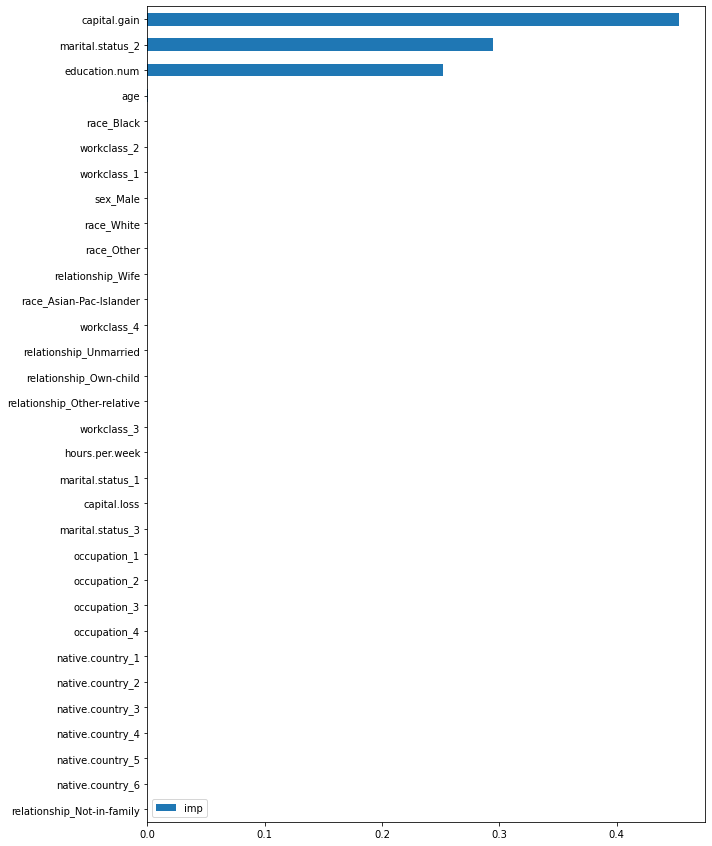

In [41]:
pd.DataFrame({'imp':model.feature_importances_},index=features).sort_values('imp').plot(kind='barh',figsize=(10,15))

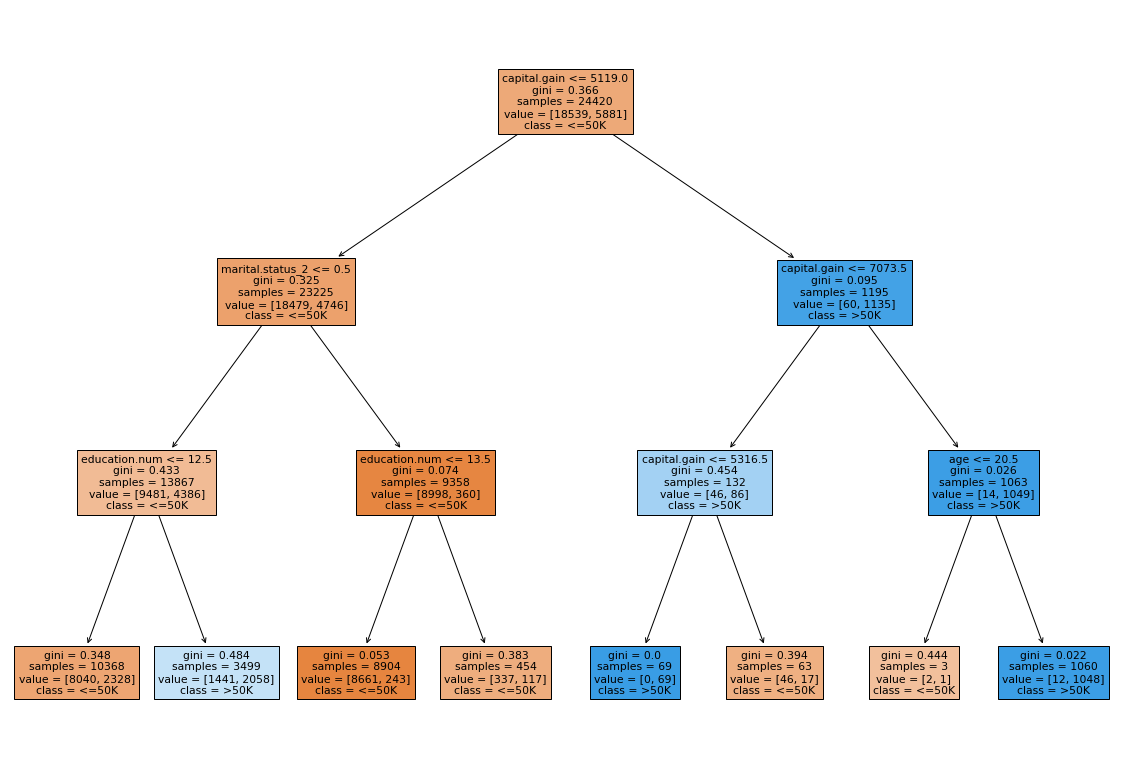

In [39]:
plt.figure(figsize=(20,14))
plot_tree(model, feature_names=features, filled=True, class_names=['<=50K', '>50K'])
plt.show()

## Adaptive Boosting

In [42]:
learner= DecisionTreeClassifier(max_depth=3)
model= AdaBoostClassifier(learner,n_estimators=200, learning_rate=0.1, random_state=10)
pipe=Pipeline([
    ('preprocess',transformer),
    ('model',model)
])

In [43]:
pipe.fit(x_train,y_train)
y_pred=pipe.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6181
           1       0.78      0.63      0.70      1960

    accuracy                           0.87      8141
   macro avg       0.84      0.79      0.81      8141
weighted avg       0.86      0.87      0.86      8141



### Model Properties

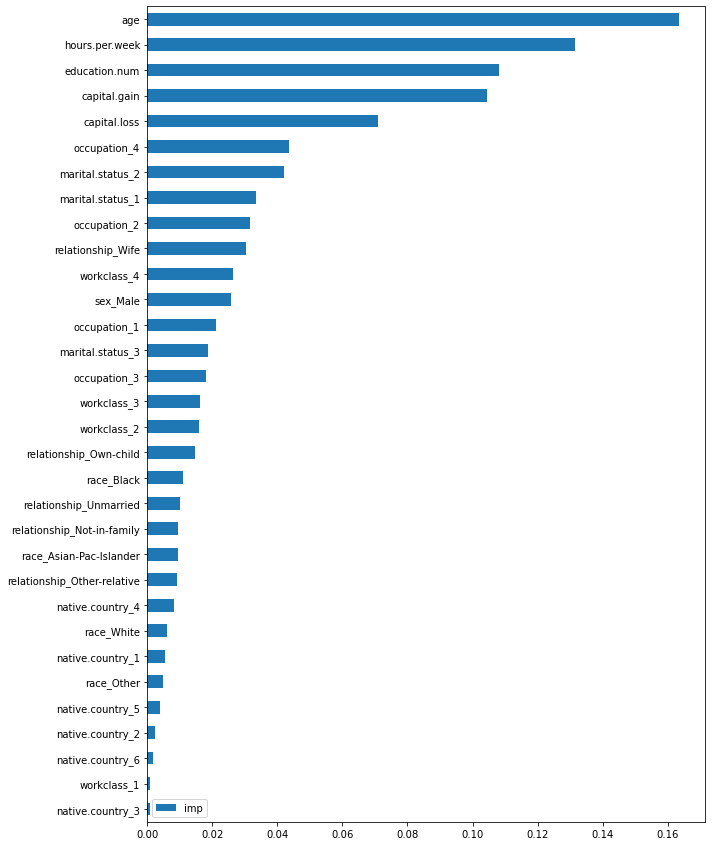

In [45]:
pd.DataFrame({'imp':model.feature_importances_},index=features).sort_values('imp').plot(kind='barh', figsize=(10,15))

In [46]:
# boosting tidak bisa plot_tree, karena, seperti random forest, merupakan gabungan dari banyak pohon.

## Gradient Boosting

In [47]:
model=GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=10
) #default learner tree dan tidak bisa diganti

pipe=Pipeline([
    ('preprocess', transformer),
    ('model',model)
])

In [48]:
pipe.fit(x_train,y_train)
y_pred=pipe.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      6181
           1       0.79      0.61      0.69      1960

    accuracy                           0.87      8141
   macro avg       0.84      0.78      0.80      8141
weighted avg       0.86      0.87      0.86      8141



### Model Properties

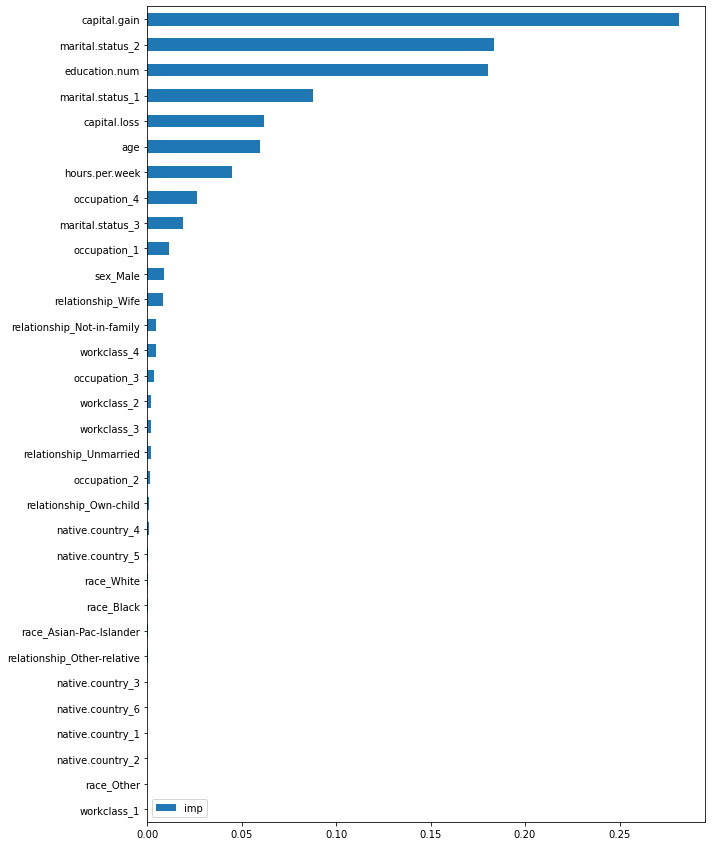

In [49]:
pd.DataFrame({'imp':model.feature_importances_},index=features).sort_values('imp').plot(kind='barh', figsize=(10,15))

## Extreme Gradient Boosting

In [50]:
model=XGBClassifier(n_estimators=200,
                   learning_rate=0.1,
                   max_depth=3,
                   random_state=10)
pipe=Pipeline([
    ('preprocess',transformer),
    ('model',model)
])

In [51]:
pipe.fit(x_train,y_train)
y_pred=pipe.predict(x_test)
print(classification_report(y_test,y_pred))

C:\Users\brigi\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:59:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      6181
           1       0.79      0.61      0.69      1960

    accuracy                           0.87      8141
   macro avg       0.84      0.78      0.80      8141
weighted avg       0.86      0.87      0.86      8141



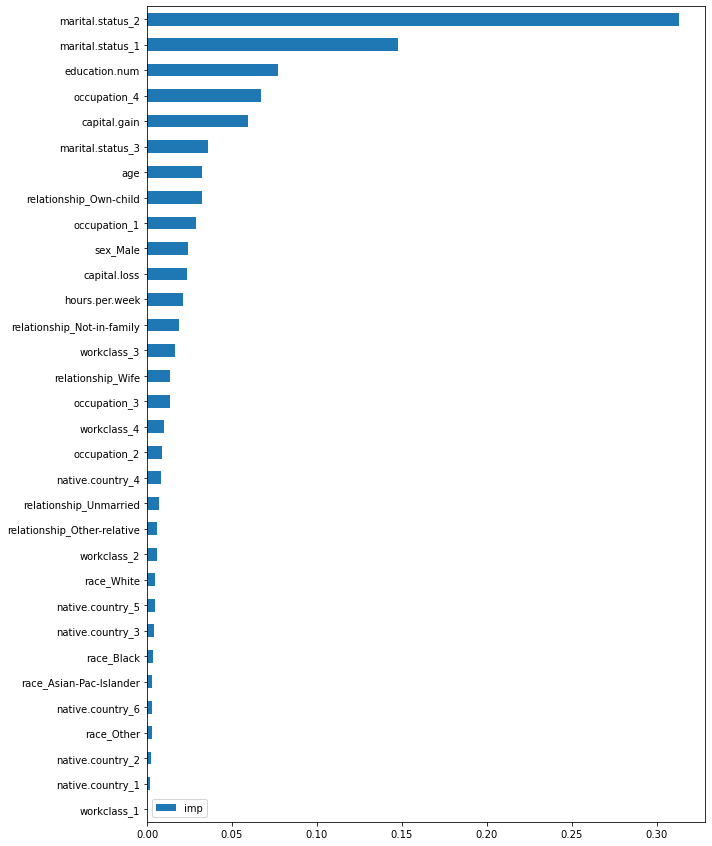

In [54]:
### Model Properties
pd.DataFrame({'imp':model.feature_importances_},index=features).sort_values('imp').plot(kind='barh', figsize=(10,15))

# Models Selection

In [56]:
model_tree= DecisionTreeClassifier(max_depth=3)
model_ada= AdaBoostClassifier(model_tree,
                              n_estimators=200,
                              learning_rate=0.1,
                              random_state=10
                             )

model_gbc=GradientBoostingClassifier(n_estimators=200, 
                                     learning_rate=0.1,
                                     random_state=10, 
                                     max_depth=3)
model_xgbc=XGBClassifier(n_estimators=200, 
                         learning_rate=0.1,
                         random_state=10, 
                         max_depth=3)

In [57]:
#mencari model benchmark terbaik menggunakan grid search
estimator=Pipeline([
    ('preprocess',transformer),
    ('model',model_tree)
])

In [58]:
hyperparam_space={
    'model':[model_tree,model_ada,model_gbc,model_xgbc]
}

In [60]:
skfold=StratifiedKFold(n_splits=5)
grid=GridSearchCV(
    estimator,
    param_grid=hyperparam_space,
    cv=skfold,
    scoring='f1',
    n_jobs=-1
)

In [61]:
grid.fit(x_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one '
                                                                         'hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['relationship',
                                                                          'race',
                                                                          'sex']),
                                                                        ('binary',
                                                                         BinaryEncoder(drop_invariant=True),
                                                                         ['

In [63]:
pd.DataFrame(grid.cv_results_)[['params','mean_test_score','std_test_score','rank_test_score']]

,params,mean_test_score,std_test_score,rank_test_score
0,{'model': DecisionTreeClassifier(max_depth=3)},0.605702,0.007411,4
1,{'model': AdaBoostClassifier(base_estimator=De...,0.705787,0.013287,1
2,{'model': GradientBoostingClassifier(n_estimat...,0.698700,0.013202,3
3,"{'model': XGBClassifier(base_score=None, boost...",0.698875,0.013476,2


In [64]:
print(grid.best_params_)
print(grid.best_score_)

{'model': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.1, n_estimators=200, random_state=10)}
0.7057867145402181


# Model Performance in Data test

In [66]:
model=grid.best_estimator_
model.fit(x_train,y_train)
print(classification_report(y_test, model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6181
           1       0.78      0.63      0.70      1960

    accuracy                           0.87      8141
   macro avg       0.84      0.79      0.81      8141
weighted avg       0.86      0.87      0.86      8141



C:\Users\brigi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


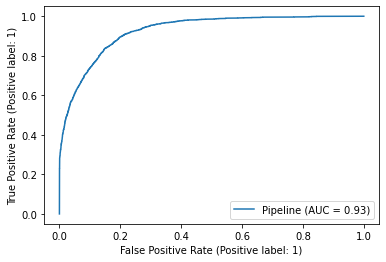

In [67]:
plot_roc_curve(grid.best_estimator_,x_test,y_test)

C:\Users\brigi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


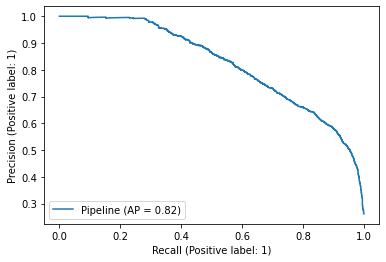

In [68]:
plot_precision_recall_curve(grid.best_estimator_,x_test,y_test)

# Hyperparam Tunning

In [69]:
model_tree=DecisionTreeClassifier(max_depth=3)
model_ada=AdaBoostClassifier(model_tree,
                            n_estimators=200,
                            learning_rate=0.1,
                            random_state=10)
estimator=Pipeline([
    ('preprocess', transformer),
    ('model',model_ada)
])

In [72]:
estimator.get_params()

{'memory': None,
 'steps': [('preprocess',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('one hot', OneHotEncoder(drop='first'),
                                    ['relationship', 'race', 'sex']),
                                   ('binary', BinaryEncoder(drop_invariant=True),
                                    ['workclass', 'marital.status', 'occupation',
                                     'native.country'])])),
  ('model',
   AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                      learning_rate=0.1, n_estimators=200, random_state=10))],
 'verbose': False,
 'preprocess': ColumnTransformer(remainder='passthrough',
                   transformers=[('one hot', OneHotEncoder(drop='first'),
                                  ['relationship', 'race', 'sex']),
                                 ('binary', BinaryEncoder(drop_invariant=True),
                                  ['workclass', 'marital.status', 'occupation

In [73]:
hyperparam_space=[
    {'model__learning_rate': [0.1],'model__n_estimators':[200],'model__base_estimator__max_depth': [3,4,5]},
    {'model__learning_rate': [0.05],'model__n_estimators':[400],'model__base_estimator__max_depth': [3,4,5]},
    {'model__learning_rate': [0.01],'model__n_estimators':[2000],'model__base_estimator__max_depth': [3,4,5]},
    {'model__learning_rate': [0.005],'model__n_estimators':[4000],'model__base_estimator__max_depth': [3,4,5]}
]

In [75]:
grid_ada=GridSearchCV(estimator,
                     param_grid=hyperparam_space,
                     cv=skfold,
                      scoring='f1',
                     n_jobs=-1)

In [76]:
grid_ada.fit(x_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one '
                                                                         'hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['relationship',
                                                                          'race',
                                                                          'sex']),
                                                                        ('binary',
                                                                         BinaryEncoder(drop_invariant=True),
                                                                         ['

In [77]:
grid_ada.best_params_, grid_ada.best_score_

({'model__base_estimator__max_depth': 4,
  'model__learning_rate': 0.1,
  'model__n_estimators': 200},
 0.7081075110947583)

## before vs after tunning

In [78]:
# before
model=grid.best_estimator_
model.fit(x_train,y_train)
print(classification_report(y_test, model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6181
           1       0.78      0.63      0.70      1960

    accuracy                           0.87      8141
   macro avg       0.84      0.79      0.81      8141
weighted avg       0.86      0.87      0.86      8141



In [79]:
# after
best_model= grid_ada.best_estimator_
best_model.fit(x_train,y_train)
print(classification_report(y_test, best_model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6181
           1       0.77      0.63      0.70      1960

    accuracy                           0.87      8141
   macro avg       0.83      0.79      0.81      8141
weighted avg       0.86      0.87      0.86      8141



In [80]:
# tunning tidak merubah performance model. Bisa dicoba parameter lain, model lain, atau kembali ke feature engineering